In [1]:
import numpy as np
import skimage
import skimage.data
import skimage.io
import os
import random
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
from matplotlib.patches import Patch
import ipywidgets as ipw
import sklearn.model_selection
import sklearn.neighbors
import sklearn.metrics
from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay, f1_score,roc_curve,auc
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
from typing import Dict, List, Tuple, Any
from ipywidgets import Layout, VBox
from ipywidgets import Tab, Output
from IPython.display import display
from plotly.subplots import make_subplots
import numpy as np
import sklearn.metrics
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential 
from typing import Any, List, Dict, Tuple
from ipywidgets import Output, Tab, Layout, VBox
from IPython.display import display
import plotly.graph_objects as go
import plotly.express as px
from sklearn.metrics import recall_score, precision_score, f1_score
import colorsys
from sklearn.metrics import accuracy_score
import tensorflow as tf
import colorsys

# Functions

In [2]:
def find_optimal_roc_point(fpr, tpr):
    distances = np.sqrt(fpr**2 + (1 - tpr)**2)
    optimal_idx = np.argmin(distances)
    return fpr[optimal_idx], tpr[optimal_idx]

In [3]:
def resize_and_save_folder(input_dir, output_dir, wscale=1.0, hscale=1.0):
    os.makedirs(output_dir, exist_ok=True)

    files = sorted([
        f for f in os.listdir(input_dir)
        if f.lower().endswith((".png", ".jpg", ".jpeg"))
    ])

    for f in files:
        in_path = os.path.join(input_dir, f)
        out_path = os.path.join(output_dir, f)

        with Image.open(in_path) as img:
            new_size = (int(img.width * wscale), int(img.height * hscale))
            img_resized = img.resize(new_size, Image.LANCZOS)
            img_resized.save(out_path)

    print(f"Saved {len(files)} images in: {output_dir}")
    

def resize_and_save_all(paths, out_root="dataset/resized", wscale=1, hscale=1):
    
    if os.path.exists(out_root):
        print(f"{out_root} already exists. Skipping resizing.")
        return
    
    out_paths = {
        key: os.path.join(out_root, key)
        for key in ["orig", "label", "rgb"]
    }

    resize_and_save_folder(paths["orig"],  out_paths["orig"],  wscale, hscale)
    resize_and_save_folder(paths["label"], out_paths["label"], wscale, hscale)
    resize_and_save_folder(paths["rgb"],   out_paths["rgb"],  wscale, hscale)

def load_resized_images(orig_dir, label_dir, rgb_dir):
    orig_image = []
    label_image = []
    rgb_image = []

    # ORIG
    orig_files = sorted([f for f in os.listdir(orig_dir) if f.endswith((".jpg",".png",".jpeg"))])
    for f in orig_files:
        orig_image.append(Image.open(os.path.join(orig_dir, f)))

    # LABEL
    label_files = sorted([f for f in os.listdir(label_dir) if f.endswith((".jpg",".png",".jpeg"))])
    for f in label_files:
        label_image.append(Image.open(os.path.join(label_dir, f)))

    # RGB
    rgb_files = sorted([f for f in os.listdir(rgb_dir) if f.endswith((".jpg",".png",".jpeg"))])
    for f in rgb_files:
        rgb_image.append(Image.open(os.path.join(rgb_dir, f)))

    return orig_image, label_image, rgb_image


In [4]:
def pick_random_centers(mask, size=100, ignore=0):
    mask_ignored = mask.copy()
    mask_ignored[:ignore,:]=False
    mask_ignored[-ignore:,:]=False
    mask_ignored[:,:ignore]=False
    mask_ignored[:,-ignore:]=False
    rs, cs = np.where(mask_ignored)
    if len(rs) < 3:
        return None,None
    ix = np.random.randint(len(rs), size=size)
    return rs[ix], cs[ix]

In [5]:
def plot_confusion_matrix(y_true, y_pred, labels=['False', 'True'], report=False, title="Confusion Matrix"):
    if report:
        print(classification_report(y_true, y_pred, digits=4))
    
    print(f"F1 Score (weighted): {f1_score(y_true, y_pred, average='weighted') * 100:.2f}%")
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues")
    plt.title(title)
    plt.tight_layout()
    plt.show()
    

In [6]:
def compile_fit_with_tabs(model: Sequential, X_train: np.ndarray, y_train: np.ndarray, 
                          X_val: np.ndarray, y_val: np.ndarray, 
                          epochs: int = 50, batch_size: int = 8, patience: int = 10,callbacks_list = None) -> Any:
    
    # Define a layout to make widgets use the full width
    full_width_layout = Layout(width='100%')
    summary_out = Output(layout=full_width_layout)
    fit_out = Output(layout=full_width_layout)
    
    # Create the Tab widget
    tab_widget = Tab(children=[summary_out, fit_out], layout=full_width_layout)
    tab_widget.set_title(0, 'Model Summary')
    tab_widget.set_title(1, 'Model Training')
    
    # Display the tab widget
    display(VBox([tab_widget], layout=Layout(width='100%', align_items='stretch')))
    
    with summary_out:
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        model.summary()
    
    with fit_out:
        
        if callbacks_list is None:
            callbacks = []
        else:
            callbacks = callbacks_list

        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            verbose=1,
            callbacks=callbacks
        )

    
    return history

In [7]:
def plot_loss_and_accuracy(history: Any, title: str = "Training History Comparison", width: int = 1150, height: int = 500):
    df = pd.DataFrame(history.history)
    epochs = df.index + 1
    
    fig = go.Figure()

    fig.add_trace(go.Scatter(x=epochs, y=df["loss"], name="Train Loss", line=dict(color='blue')))
    fig.add_trace(go.Scatter(x=epochs, y=df["val_loss"], name="Validation Loss", line=dict(color='red', dash='dot')))\
    
    if 'accuracy' in df.columns:
        fig.add_trace(go.Scatter(x=epochs, y=df["accuracy"], name="Train Accuracy", line=dict(color='green')))
        fig.add_trace(go.Scatter(x=epochs, y=df["val_accuracy"], name="Validation Accuracy", line=dict(color='orange', dash='dot')))
    elif 'binary_accuracy' in df.columns:
        fig.add_trace(go.Scatter(x=epochs, y=df["binary_accuracy"], name="Train Accuracy", line=dict(color='green')))
        fig.add_trace(go.Scatter(x=epochs, y=df["val_binary_accuracy"], name="Validation Accuracy", line=dict(color='orange', dash='dot')))
    else:
        pass
        
    fig.update_layout(title_text=title,xaxis_title="Epoch", height=height,width=width)
    fig.show()

def plot_metrics_comparison(loss_values: List[float], acc_values: List[float], title: str = "Final Metrics Comparison", width: int = 1150, height: int = 500):
   
    labels = ['Training', 'Validation', 'Test']
    
    fig = make_subplots(rows=1, cols=2, subplot_titles=("Accuracy", "Loss (Binary Crossentropy)")) 
    colors = ['#4CAF50', '#FFC107', '#007BFF']

    fig.add_trace(go.Bar(x=labels, y=acc_values, name="Accuracy", marker_color=colors), row=1, col=1)
    fig.add_trace(go.Bar(x=labels, y=loss_values, name="Loss", marker_color=colors), row=1, col=2)
    
    fig.update_layout(title_text=title, showlegend=False,height=height, width=width)
    
    fig.update_yaxes(title_text="Accuracy", range=[0, 1.05], row=1, col=1)
    fig.update_yaxes(title_text="Loss Value", row=1, col=2)
    
    fig.show()


def show_classification_results(
    model: Sequential,
    history: Any, 
    X_train: np.ndarray, 
    y_train: np.ndarray,
    X_val: np.ndarray, 
    y_val: np.ndarray,
    X_test: np.ndarray, 
    y_test: np.ndarray,
    plot_width: int = 800, 
    plot_height: int = 500,
    threshold: float = 0.5
):
   
    results_train = model.evaluate(X_train, y_train, verbose=0)
    results_val = model.evaluate(X_val, y_val, verbose=0)
    results_test = model.evaluate(X_test, y_test, verbose=0)
    
    loss_train, acc_train = results_train[0], results_train[1]
    loss_val, acc_val = results_val[0], results_val[1]
    loss_test, acc_test = results_test[0], results_test[1]
    
    y_val_pred_proba = model.predict(X_val, verbose=0)
    y_test_pred_proba = model.predict(X_test, verbose=0)

    y_val_true_bin = y_val.flatten().astype(int)
    y_val_pred_proba_flat = y_val_pred_proba.flatten()
    y_val_pred_bin = (y_val_pred_proba_flat > threshold).astype(int)

    y_test_true_bin = y_test.flatten().astype(int)
    y_test_pred_proba_flat = y_test_pred_proba.flatten()
    y_test_pred_bin = (y_test_pred_proba_flat > threshold).astype(int)
    
    acc_val_thresholded = accuracy_score(y_val_true_bin, y_val_pred_bin)
    acc_test_thresholded = accuracy_score(y_test_true_bin, y_test_pred_bin)
    
    
    loss_values = [loss_train, loss_val, loss_test]
    acc_values = [acc_train, acc_val_thresholded, acc_test_thresholded]

    full_width_layout = Layout(width='100%')
    history_out = Output(layout=full_width_layout)
    metrics_out = Output(layout=full_width_layout)
    cm_out = Output(layout=full_width_layout)
    
    tab_widget = Tab(children=[history_out, metrics_out, cm_out], layout=full_width_layout)
    tab_widget.set_title(0, 'Training History (Loss & Acc)')
    tab_widget.set_title(1, 'Final Metrics')
    tab_widget.set_title(2, 'Confusion Matrix')
    
    display(VBox([tab_widget], layout=Layout(width='100%', align_items='stretch')))
    
    with history_out:
        plot_loss_and_accuracy(history, width=plot_width, height=plot_height)

    with metrics_out:
        plot_metrics_comparison(loss_values, acc_values, width=plot_width, height=plot_height)
        
    with cm_out:
        plot_confusion_matrix(y_test_true_bin, y_test_pred_bin, title='Confusion Matrix on Test Set')

In [8]:
def plot_roc_curve(y_true, scores, title="ROC Curve"):
    fpr, tpr, _ = roc_curve(y_true, scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 1. Read Dataset

In [9]:
base = "dataset"
paths = {
    "label": os.path.join(base, "label_images_semantic"),
    "orig": os.path.join(base, "original_images"),
    "rgb":  os.path.join(base, "RGB_color_image_masks")
}

orig_files = sorted([f for f in os.listdir(paths["orig"]) if f.endswith(".jpg")])
df = pd.read_csv(os.path.join(base, "class_dict_seg.csv"))
color_items = [(row["name"], (int(row["r"]), int(row["g"]), int(row["b"]))) for i, row in df.iterrows()]


In [10]:
n_total = len(orig_files)

### 1.1. Index checks 

In [11]:
for name, path in paths.items():
    count = len([f for f in os.listdir(path) if f.lower().endswith((".jpg",".png"))])
    print(f"{name} images: {count}")

label images: 400
orig images: 400
rgb images: 400


In [12]:
indices = [int(os.path.splitext(f)[0]) for f in orig_files]

print("Lowest index:", min(indices))
print("Highest index:", max(indices))

Lowest index: 0
Highest index: 399


In [13]:
expected = set(range(min(indices), max(indices)+1))
actual = set(indices)

missing = sorted(list(expected - actual))

if missing:
    print("Missing indices:", missing)
else:
    print("No missing indices, numbering is continuous.")

No missing indices, numbering is continuous.


In [14]:
print(f"Da eseguire solo una volta per mettere a posto il nome delle immagini siccome alcune sono mancanti")

# # Rename all files with a "t_" prefix to avoid name conflicts
# for new_idx, f_jpg in enumerate(orig_files):
#     base_name = os.path.splitext(f_jpg)[0]
#     f_png = base_name + ".png"

#     temp_name_jpg = f"t_{new_idx:03d}.jpg"
#     temp_name_png = f"t_{new_idx:03d}.png"

#     # Rename original image
#     os.rename(os.path.join(paths["orig"], f_jpg),
#               os.path.join(paths["orig"], temp_name_jpg))
#     # Rename label image
#     os.rename(os.path.join(paths["label"], f_png),
#               os.path.join(paths["label"], temp_name_png))
#     # Rename RGB mask
#     os.rename(os.path.join(paths["rgb"], f_png),
#               os.path.join(paths["rgb"], temp_name_png))

# # Now remove the "t_" prefix to set new numbering
# for f in os.listdir(paths["orig"]):
#     if f.startswith("t_"):
#         new_name = f.replace("t_", "")
#         os.rename(os.path.join(paths["orig"], f),
#                   os.path.join(paths["orig"], new_name))

# for f in os.listdir(paths["label"]):
#     if f.startswith("t_"):
#         new_name = f.replace("t_", "")
#         os.rename(os.path.join(paths["label"], f),
#                   os.path.join(paths["label"], new_name))

# for f in os.listdir(paths["rgb"]):
#     if f.startswith("t_"):
#         new_name = f.replace("t_", "")
#         os.rename(os.path.join(paths["rgb"], f),
#                   os.path.join(paths["rgb"], new_name))

Da eseguire solo una volta per mettere a posto il nome delle immagini siccome alcune sono mancanti


### 1.2. Manage dataset

In [15]:
orig_files = sorted([f for f in os.listdir(paths["orig"]) if f.endswith(".jpg")])
label_files = sorted([f for f in os.listdir(paths["label"]) if f.endswith(".png")])
RGB_files = sorted([f for f in os.listdir(paths["rgb"]) if f.endswith(".png")])
scale = 0.25

In [16]:
resize_and_save_all(paths, out_root="dataset/resized", wscale=scale, hscale=scale)

dataset/resized already exists. Skipping resizing.


In [17]:
orig_image, label_image, rgb_image = load_resized_images(
    "dataset/resized/orig",
    "dataset/resized/label",
    "dataset/resized/rgb"
)

### 1.3. Image visualizations

- Visualize some images and corresponding segmentation masks.

In [ ]:
@ipw.interact(index=ipw.IntSlider(min=0,max=len(orig_image)-1))

def plot_images(index):
    plt.figure(figsize=(9,3))
    plt.suptitle(f"Index {index}")
    
    plt.subplot(1,3,1)
    plt.imshow(orig_image[index])
    plt.title("Original")
    plt.axis('off')
    
    plt.subplot(1,3,2)
    plt.imshow(label_image[index])
    plt.title("Label")
    plt.axis('off')
    
    plt.subplot(1,3,3)
    plt.imshow(rgb_image[index])
    plt.title("RGB Mask")
    plt.axis('off')
    
    plt.show()

interactive(children=(IntSlider(value=0, description='index', max=399), Output()), _dom_classes=('widget-inter…

In [ ]:
@ipw.interact(index=ipw.IntSlider(min=0,max=len(orig_image)-1))

def plot_images_labels(index):
    
    img_rgb = rgb_image[index]
    arr = np.array(img_rgb).reshape(-1,3)
    unique_colors = {tuple(c) for c in arr}

    present = [(name,(r,g,b)) for name,(r,g,b) in color_items if (r,g,b) in unique_colors]

    plt.figure(figsize=(11,4))
    plt.suptitle(f"Index {index}")
    plt.subplot(1,2,1)
    plt.imshow(orig_image[index])
    plt.title("Original")
    plt.axis('off')
    
    plt.subplot(1,2,2)
    plt.imshow(rgb_image[index])
    plt.title("RGB Mask")
    plt.axis('off')

    handles = [Patch(facecolor=(r/255,g/255,b/255), label=name) for name,(r,g,b) in present]
    plt.legend(handles=handles, bbox_to_anchor=(1.02,1), loc='upper left', fontsize='small')
    plt.show()

interactive(children=(IntSlider(value=0, description='index', max=399), Output()), _dom_classes=('widget-inter…

# 2. Patches segmentation

### 2.1. Create binary image

In [20]:
vegetation = np.array([107,142,35])
grass = np.array([0,102,0])
#tree = np.array([51,51,0])

In [21]:
scale = 0.25  
n_points = 3
size = 16
# out_dir = os.path.join(base, "binary_veg")
# os.makedirs(out_dir, exist_ok=True)

In [22]:
binary_im = []

for image in rgb_image:
        
    arr = np.array(image)

    # binarization 1 for vegetable and 0 otherwise
    
    #mask = (np.all(arr == vegetation, axis=-1) | np.all(arr == grass, axis=-1) | np.all(arr == tree, axis=-1))
    mask = (np.all(arr == vegetation, axis=-1) | np.all(arr == grass, axis=-1))
    mask_img = mask.astype(np.uint8) * 255

    binary_im.append(mask_img)


In [23]:
@ipw.interact(index=ipw.IntSlider(min=0, max=len(orig_image) - 1))
def plot_images_binary(index):
    orig_img = orig_image[index]
    
    binary_mask = binary_im[index]

    plt.figure(figsize=(11, 4))
    plt.suptitle(f"Index {index}: Original Image vs. Binary Vegetation Mask")

    plt.subplot(1, 2, 1)
    plt.imshow(orig_img)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(binary_mask, cmap='gray')
    plt.title("Binary Vegetation Mask")
    plt.axis('off')

    handles = [
        Patch(facecolor='black', label='Non Vegetation (0)'),
        Patch(facecolor='white', label='Vegetation (255)')
    ]
    
    plt.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='medium')
    
    plt.tight_layout(rect=[0, 0, 0.95, 1])  
    plt.show()


interactive(children=(IntSlider(value=0, description='index', max=399), Output()), _dom_classes=('widget-inter…

### 2.2. Create patches

In [24]:
patches = []
labels = []
patch_img_idx = []
coords_dict = {}  

for i in range(len(binary_im)):
    orig = np.array(orig_image[i])
    binary = binary_im[i]    
      
    rs_veg, cs_veg = pick_random_centers(binary, size=n_points, ignore=size)
    if rs_veg is None:
        rs_veg, cs_veg = np.array([]), np.array([])
    
    rs_nonveg, cs_nonveg = pick_random_centers(~binary, size=n_points, ignore=size)
    if rs_nonveg is None:
        rs_nonveg, cs_nonveg = np.array([]), np.array([])
    
    coords_dict[i] = {
        "veg": (rs_veg, cs_veg),
        "nonveg": (rs_nonveg, cs_nonveg)
    }

    for r,c in zip(rs_veg, cs_veg):
        patches.append(orig[r-size:r+size, c-size:c+size, :])
        labels.append(binary[r,c])
        patch_img_idx.append(i)

    for r,c in zip(rs_nonveg, cs_nonveg):
        patches.append(orig[r-size:r+size, c-size:c+size, :])
        labels.append(binary[r,c])
        patch_img_idx.append(i)


In [ ]:
@ipw.interact(index=ipw.IntSlider(min=0, max=len(orig_image)-1))
def plot_patches(index):
    rs_veg, cs_veg = coords_dict[index]["veg"]
    rs_nonveg, cs_nonveg = coords_dict[index]["nonveg"]

    patches_i = [p for p, idx in zip(patches, patch_img_idx) if idx == index]
    n_veg = len(rs_veg)
    n_nonveg = len(rs_nonveg)

    fig = plt.figure(figsize=(12,5))
    
    # Original Image
    ax0 = fig.add_subplot(1,2,1)
    ax0.imshow(orig_image[index])
    ax0.scatter(cs_veg, rs_veg, c='red', label='Vegetation', s=25)
    ax0.scatter(cs_nonveg, rs_nonveg, c='yellow', label='Non Vegetation', s=25)
    ax0.set_title(f"Original {index}")
    ax0.legend()

    # Vegetation
    for i, patch in enumerate(patches_i[:n_veg]):
        ax = fig.add_subplot(2, max(n_veg,n_nonveg), i+1,position=[0.55 + i*0.12, 0.52, 0.12, 0.25])
        ax.imshow(patch)
        ax.axis('off')
        if i == 0:
            ax.set_title("Vegetation")

    # Non-Vegetation
    for i, patch in enumerate(patches_i[n_veg:n_veg+n_nonveg]):
        ax = fig.add_subplot(2, max(n_veg,n_nonveg), i+1,position=[0.55 + i*0.12, 0.20, 0.12, 0.25])
        ax.imshow(patch)
        ax.axis('off')
        if i == 0:
            ax.set_title("Non Vegetation")

    plt.show()


interactive(children=(IntSlider(value=0, description='index', max=399), Output()), _dom_classes=('widget-inter…

In [26]:
patches_array = np.array(patches)
labels_array = np.array(labels, dtype=np.uint8)

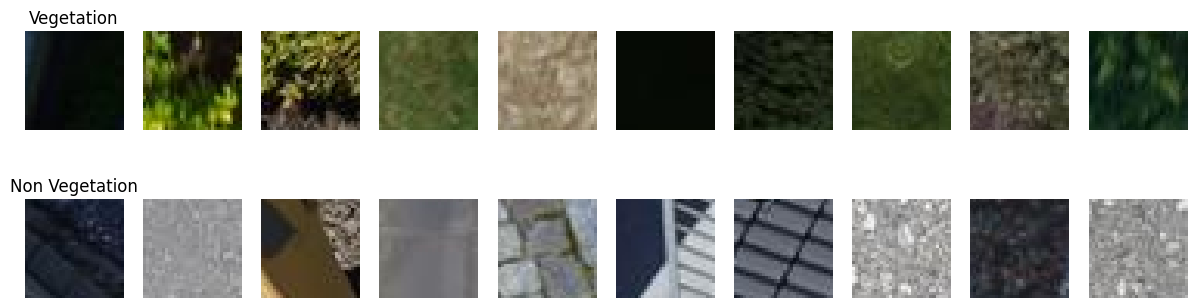

In [27]:
# 10 random index from vegetation and non-vegetation patches
random_indices_veg = random.sample([i for i, lbl in enumerate(labels_array/255) if lbl == 1], 10)
random_indices_nonveg = random.sample([i for i, lbl in enumerate(labels_array/255) if lbl == 0], 10)

# Plot random patches
fig, axes = plt.subplots(2, 10, figsize=(15, 4))
for i, idx in enumerate(random_indices_veg):
    axes[0, i].imshow(patches_array[idx])
    axes[0, i].axis('off')
    if i == 0:
        axes[0, i].set_title("Vegetation")
        
for i, idx in enumerate(random_indices_nonveg):
    axes[1, i].imshow(patches_array[idx])
    axes[1, i].axis('off')
    if i == 0:
        axes[1, i].set_title("Non Vegetation")
plt.show()

### 2.3. KNN-classifier

In [28]:
N_patches = patches_array.shape[0]
feature_vectors = patches_array.reshape(N_patches, -1)

print(f"Shape feautures: {feature_vectors.shape}")
print(f"Shape labels: {labels_array.shape}")

Shape feautures: (2376, 3072)
Shape labels: (2376,)


In [29]:
X_train_val_knn, X_test_knn, y_train_val_knn, y_test_knn = sklearn.model_selection.train_test_split(
    feature_vectors, 
    labels_array, 
    test_size=0.3,  
    random_state=42, 
    stratify=labels_array 
)


X_train_knn, X_val_knn, y_train_knn, y_val_knn = sklearn.model_selection.train_test_split(
    X_train_val_knn, 
    y_train_val_knn, 
    test_size=0.3, 
    random_state=42, 
    stratify=y_train_val_knn
)

In [30]:
print(f"Training X: {X_train_knn.shape}, y: {y_train_knn.shape}")
print(f"Validation X: {X_val_knn.shape}, y: {y_val_knn.shape}")
print(f"Test X: {X_test_knn.shape}, y: {y_test_knn.shape}")

Training X: (1164, 3072), y: (1164,)
Validation X: (499, 3072), y: (499,)
Test X: (713, 3072), y: (713,)


In [31]:
knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_knn, y_train_knn)

,n_neighbors,3
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [32]:
y_pred = knn.predict(X_test_knn)

F1 Score (weighted): 77.52%


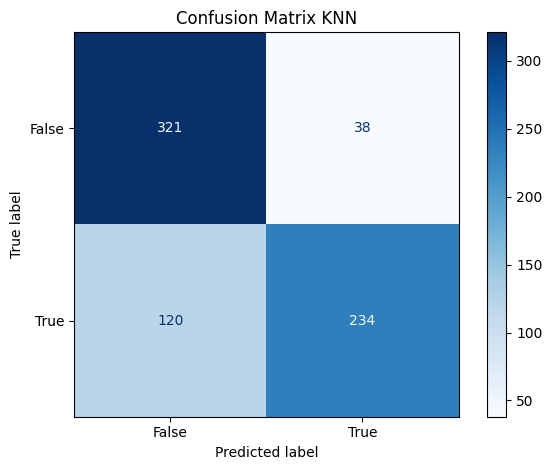

In [33]:
plot_confusion_matrix(y_test_knn, y_pred, report=False, title="Confusion Matrix KNN")

### 2.4 Convolutional NN

In [34]:
X_train_val, X_test, y_train_val, y_test = sklearn.model_selection.train_test_split(
    patches_array, labels_array, test_size=0.3, random_state=42, stratify=labels_array 
)

X_train, X_val, y_train, y_val = sklearn.model_selection.train_test_split(
    X_train_val, y_train_val, test_size=0.3, random_state=42, stratify=y_train_val 
)

In [35]:
print(f"Training X: {X_train.shape}, y: {y_train.shape}")
print(f"Validation X: {X_val.shape}, y: {y_val.shape}")
print(f"Test X: {X_test.shape}, y: {y_test.shape}")

Training X: (1164, 32, 32, 3), y: (1164,)
Validation X: (499, 32, 32, 3), y: (499,)
Test X: (713, 32, 32, 3), y: (713,)


In [36]:
def build_model(input_shape, num_classes):
    m = Sequential()
    
    m.add(Conv2D(32, (3,3), padding='same', input_shape=input_shape))
    m.add(Activation('relu'))
    m.add(Conv2D(32, (3,3)))
    m.add(Activation('relu'))
    m.add(MaxPooling2D((2,2)))
    m.add(Dropout(0.25))

    m.add(Conv2D(64, (3,3), padding='same'))
    m.add(Activation('relu'))
    m.add(Conv2D(64, (3,3)))
    m.add(Activation('relu'))
    m.add(MaxPooling2D((2,2)))
    m.add(Dropout(0.25))

    m.add(Flatten())
    m.add(Dense(512))
    m.add(Activation('relu'))
    m.add(Dropout(0.5))
    m.add(Dense(num_classes))
    
    if num_classes == 1:
        m.add(Activation('sigmoid'))
    else:
        m.add(Activation('softmax'))
    
    return m

In [37]:
X_train_norm = X_train.astype(float) / 255
X_val_norm = X_val.astype(float) / 255
X_test_norm = X_test.astype(float) / 255

y_train_bin = y_train / 255 
y_val_bin = y_val / 255
y_test_bin = y_test / 255

In [38]:
model_cnn = build_model(input_shape=X_train.shape[1:], num_classes=1)
model_cnn.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])


c:\Users\Sergio\.virtualenvs\Computer_Vision_Project-P0JWyP0C\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [39]:
es = EarlyStopping(monitor="val_loss", patience=30, restore_best_weights=True)

history_cnn = compile_fit_with_tabs(
    model_cnn, X_train_norm, y_train_bin, X_val_norm, y_val_bin, 
    epochs=30, batch_size=32, patience=30, callbacks_list=[es]
)

#### 2.5.1. Analysis of the model 

In [40]:
y_pred_proba = model_cnn.predict(X_test_norm, verbose=0).flatten()
y_pred_proba_val = model_cnn.predict(X_val_norm, verbose=0).flatten()

In [41]:
thresholds = np.linspace(0,1, 200)
recall_values = []
precision_values = []
f1_values = []

for t in thresholds:
    y_pred = (y_pred_proba_val > t).astype(int)

    recall = recall_score(y_val_bin, y_pred, zero_division=0)
    precision = precision_score(y_val_bin, y_pred, zero_division=0)
    f1 = f1_score(y_val_bin, y_pred, zero_division=0)

    recall_values.append(recall)
    precision_values.append(precision)
    f1_values.append(f1)
    
best_idx = np.argmax(f1_values)
best_threshold = thresholds[best_idx]
print(f"\nBest Threshold (F1): {best_threshold}")


Best Threshold (F1): 0.24120603015075376


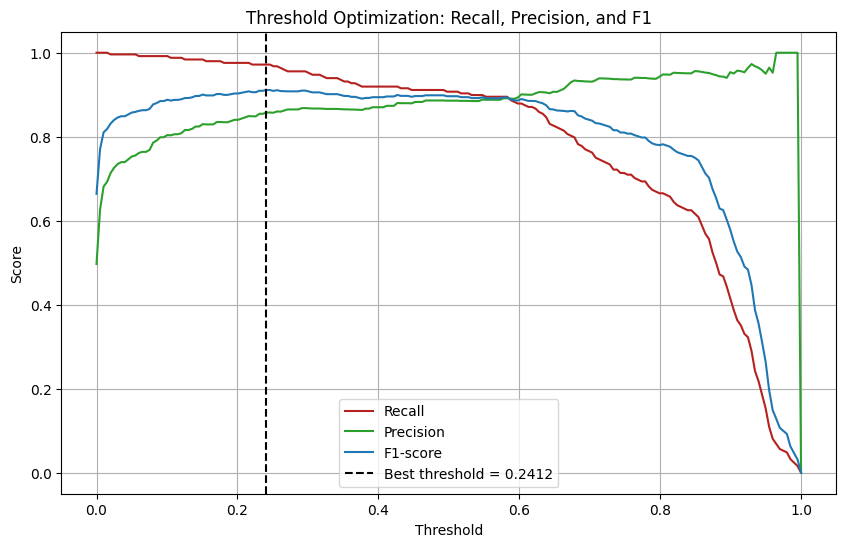

In [42]:
plt.figure(figsize=(10, 6))
plt.plot(thresholds, recall_values, label="Recall", color="#b4211f")
plt.plot(thresholds, precision_values, label="Precision", color="#2ca02c")
plt.plot(thresholds, f1_values, label="F1-score", color="#1f77b4")
plt.axvline(best_threshold, color='black', linestyle="--", label=f"Best threshold = {best_threshold:.4f}")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Threshold Optimization: Recall, Precision, and F1")
plt.legend()
plt.grid(True)
plt.show()

In [43]:
show_classification_results(
     model=model_cnn, 
     history=history_cnn, 
     X_train=X_train_norm, 
     y_train=y_train_bin,
     X_val=X_val_norm,
     y_val=y_val_bin,
     X_test=X_test_norm,
     y_test=y_test_bin,
     threshold=best_threshold
 )

In [44]:
df_results = pd.DataFrame({
    'patch': list(X_test),
    'y_true': y_test_bin,
    'y_proba': y_pred_proba.flatten()
})

df_sorted = df_results.sort_values(by='y_proba', ascending=True).reset_index(drop=True)
df_low_prob = df_sorted.head(5)
df_high_prob = df_sorted.tail(5)
df_to_plot = pd.concat([df_low_prob, df_high_prob])

df_results['error'] = np.abs(df_results['y_true'] - df_results['y_proba'])
df_sorted_error = df_results.sort_values(by='error', ascending=False).reset_index(drop=True)
df_most_wrong = df_sorted_error.head(5)

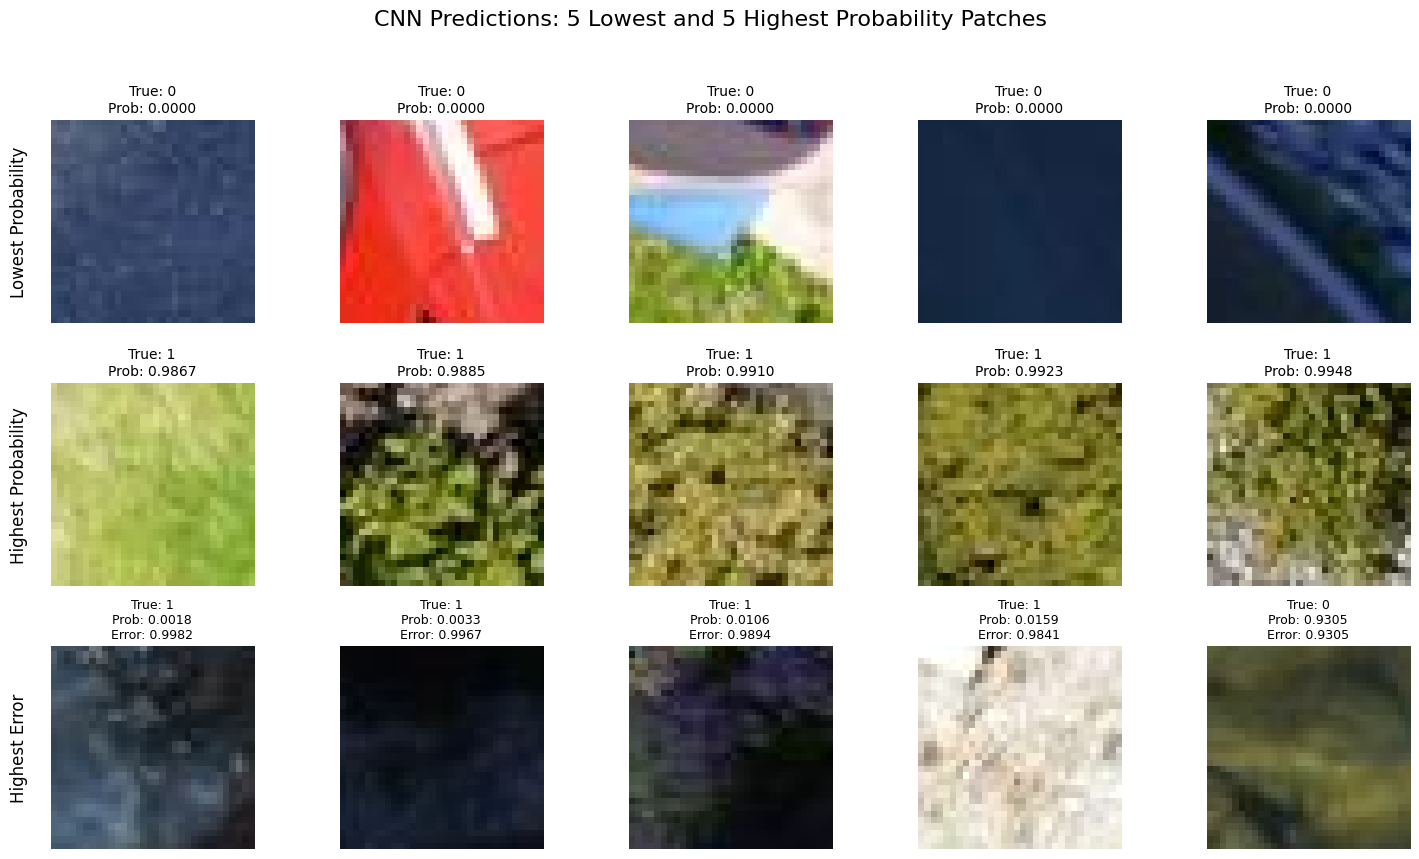

In [45]:
fig, axes = plt.subplots(3, 5, figsize=(15, 9)) 
fig.suptitle('CNN Predictions: 5 Lowest and 5 Highest Probability Patches', fontsize=16)

for i, row in df_low_prob.iterrows():
    ax = axes[0, i]
    ax.imshow(row['patch'])
    ax.set_title(f"True: {int(row['y_true'])}\nProb: {row['y_proba']:.4f}", fontsize=10)
    ax.axis('off')

for i, row in df_high_prob.reset_index(drop=True).iterrows():
    ax = axes[1, i]
    ax.imshow(row['patch'])
    ax.set_title(f"True: {int(row['y_true'])}\nProb: {row['y_proba']:.4f}", fontsize=10)
    ax.axis('off')
    
for i, row in df_most_wrong.iterrows():
    ax = axes[2, i]
    ax.imshow(row['patch'])
    ax.set_title(f"True: {int(row['y_true'])}\nProb: {row['y_proba']:.4f}\nError: {row['error']:.4f}", fontsize=9)
    ax.axis('off')

axes[0, 0].text(-0.2, 0.5, "Lowest Probability", rotation=90, va='center', transform=axes[0, 0].transAxes, fontsize=12)
axes[1, 0].text(-0.2, 0.5, "Highest Probability", rotation=90, va='center', transform=axes[1, 0].transAxes, fontsize=12)
axes[2, 0].text(-0.2, 0.5, "Highest Error", rotation=90, va='center', transform=axes[2, 0].transAxes, fontsize=12)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [46]:
# Mean patch for R G B
mean_rgb = X_test.mean(axis=(1, 2))
mean_rgb.shape
hsv_values = []

for rgb in mean_rgb:
    r, g, b = rgb / 255.0
    h, _, _ = colorsys.rgb_to_hsv(r, g, b)
    hsv_values.append(h*360)
    

In [47]:
plot_df = pd.DataFrame({
    'Mean_R': mean_rgb[:, 0],
    'Mean_G': mean_rgb[:, 1],
    'Mean_B': mean_rgb[:, 2],
    'Pred_Prob': y_pred_proba
})

fig = px.scatter_3d(
    plot_df, 
    x='Mean_R', 
    y='Mean_G', 
    z='Mean_B',
    color=y_pred_proba.flatten() * 100, 
    color_continuous_scale='Viridis', 
    title='3D Scatter Plot of Mean RGB Values vs Predicted Probability'
)


fig.update_traces(marker=dict(size=5,opacity=0.7,line=dict(color='black',width=0.5)))
fig.update_coloraxes(colorbar_title="Probability (%)")

fig.update_layout(width=900,height=700,scene=dict(aspectmode='manual',aspectratio=dict(x=1, y=1, z=1)  ))

fig.show()

In [48]:
def hue_to_rgb_plotly(h):
    r, g, b = colorsys.hsv_to_rgb(h/360, 1, 1)
    return f"rgb({int(r*255)}, {int(g*255)}, {int(b*255)})"

In [49]:
colors = [hue_to_rgb_plotly(h) for h in hsv_values]

In [50]:
fig = px.scatter(x=hsv_values,y=y_pred_proba) 
fig.update_traces(marker=dict(color=colors,size=7,line=dict(color='black', width=0.5),opacity=0.8)) 
fig.update_layout(
    title="Probability of the model based on Mean HSV Value",
    xaxis_title="Hue value",
    yaxis_title="Probability of the model"
)
fig.show()

### 2.5 Comparison KNN vs CNN

In [51]:
X_test_flattened = X_test.reshape(X_test.shape[0], -1)

y_pred_proba_cnn = y_pred_proba.flatten()
y_pred_proba_knn = knn.predict_proba(X_test_flattened)[:, 1]

# KNN ROC
fpr_knn, tpr_knn, _ = roc_curve(y_test_bin, y_pred_proba_knn)
roc_auc_knn = auc(fpr_knn, tpr_knn)

# CNN ROC
fpr_cnn, tpr_cnn, _ = roc_curve(y_test_bin, y_pred_proba_cnn)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)

In [52]:
fpr_opt, tpr_opt = find_optimal_roc_point(fpr_cnn, tpr_cnn)

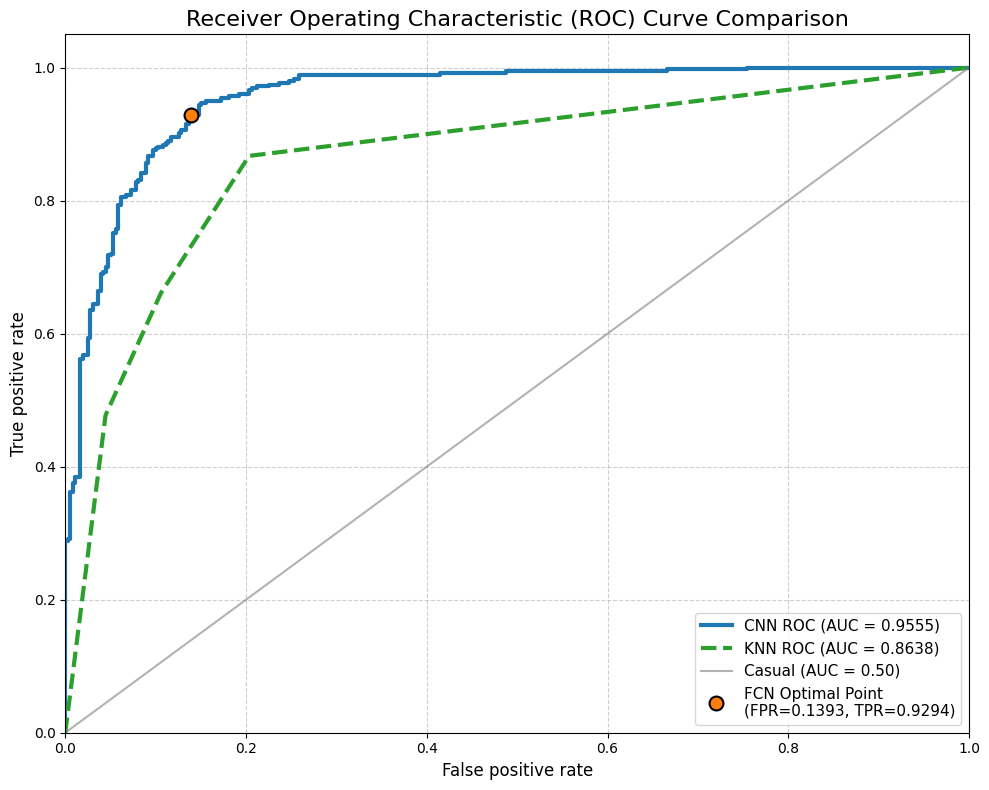

In [53]:

plt.figure(figsize=(10, 8))
plt.title('Receiver Operating Characteristic (ROC) Curve Comparison', fontsize=16)

# Plot CNN ROC
plt.plot(fpr_cnn, tpr_cnn, color='#1f77b4', lw=3, label=f'CNN ROC (AUC = {roc_auc_cnn:.4f})')

# Plot KNN ROC 
plt.plot(fpr_knn, tpr_knn, color='#2ca02c', lw=3, linestyle='--', label=f'KNN ROC (AUC = {roc_auc_knn:.4f})')

# Casual Comparison
plt.plot([0, 1], [0, 1], color='gray', lw=1.5, linestyle='-', alpha=0.6,label='Casual (AUC = 0.50)')

# Optimal point for CNN
plt.plot(
    fpr_opt, tpr_opt, 'o', markersize=10, 
    color='#ff7f0e', markeredgecolor='black', markeredgewidth=1.5, 
    label=f'FCN Optimal Point \n(FPR={fpr_opt:.4f}, TPR={tpr_opt:.4f})'
)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False positive rate', fontsize=12)
plt.ylabel('True positive rate', fontsize=12)
plt.legend(loc="lower right", fontsize=11)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [54]:
# Results for cnn model
results_train = model_cnn.evaluate(X_train_norm, y_train_bin, verbose=0)
results_val = model_cnn.evaluate(X_val_norm, y_val_bin, verbose=0)
results_test = model_cnn.evaluate(X_test_norm, y_test_bin, verbose=0)

loss_train_cnn, acc_train_cnn = results_train[0], results_train[1]
loss_val_cnn, acc_val_cnn = results_val[0], results_val[1]
loss_test_cnn, acc_test_cnn = results_test[0], results_test[1]

# Results for knn model
acc_train_knn = knn.score(X_train_knn, y_train_knn)
acc_val_knn = knn.score(X_val_knn, y_val_knn)
acc_test_knn = knn.score(X_test_knn, y_test_knn)

loss_train_knn = 1 - acc_train_knn
loss_val_knn = 1 - acc_val_knn
loss_test_knn = 1 - acc_test_knn

In [55]:
df_plot_comparison = pd.DataFrame({
    'Dataset': ['Training', 'Validation', 'Test'],
    'CNN Accuracy': [acc_train_cnn, acc_val_cnn, acc_test_cnn],
    'KNN Accuracy': [acc_train_knn, acc_val_knn, acc_test_knn],
    'CNN Loss': [loss_train_cnn, loss_val_cnn, loss_test_cnn],
    'KNN Loss': [loss_train_knn, loss_val_knn, loss_test_knn]
})

In [56]:
fig = make_subplots(rows=1, cols=2, subplot_titles=("Accuracy Comparison", "Loss Comparison"))

fig.add_trace(go.Bar(x=df_plot_comparison['Dataset'], y=df_plot_comparison['CNN Accuracy'], name='CNN Accuracy', marker_color="#1f9bb4"), row=1, col=1)
fig.add_trace(go.Bar(x=df_plot_comparison['Dataset'], y=df_plot_comparison['KNN Accuracy'], name='KNN Accuracy', marker_color="#2c30a0"), row=1, col=1)
fig.add_trace(go.Bar(x=df_plot_comparison['Dataset'], y=df_plot_comparison['CNN Loss'], name='CNN Loss', marker_color="#33ed6e"), row=1, col=2)
fig.update_layout(title_text="CNN vs KNN: Accuracy and Loss Comparison", showlegend=True, height=500, width=1000)
fig.update_yaxes(title_text="Accuracy", range=[0, 1.05], row=1, col=1)
fig.update_yaxes(title_text="Loss Value", row=1, col=2)
fig.show()

# 3. Semantic Segmentation

In [57]:
resize_and_save_all(paths, out_root="dataset/resized_100", wscale=0.0246666667, hscale=0.025)

dataset/resized_100 already exists. Skipping resizing.


In [58]:
orig_100, label_100, rgb_100= load_resized_images(
    "dataset/resized_100/orig",
    "dataset/resized_100/label",
    "dataset/resized_100/rgb"
)

In [59]:
binary_mask_100 = []

for image in rgb_100:
        
    arr = np.array(image)
    mask = (np.all(arr == vegetation, axis=-1) | np.all(arr == grass, axis=-1))
    mask_img = mask.astype(np.uint8) * 255

    binary_mask_100.append(mask_img)

In [60]:
orig_100_np = np.array([np.array(img) for img in orig_100]).astype('float32') / 255.0
binary_mask_100_np = np.array(binary_mask_100).astype('float32') / 255.0

In [61]:
binary_mask_100_np = np.expand_dims(binary_mask_100_np, axis=-1)

print(f"\nConverted arrays:")
print(f"orig_100_np shape: {orig_100_np.shape}")  
print(f"binary_mask_100_np shape: {binary_mask_100_np.shape}")  


Converted arrays:
orig_100_np shape: (400, 100, 148, 3)
binary_mask_100_np shape: (400, 100, 148, 1)


### 3.1 CNN model

In [62]:
X_train_val_100, X_test_100, y_train_val_100, y_test_100 = sklearn.model_selection.train_test_split(
    orig_100_np, 
    binary_mask_100_np,
    test_size=0.1,  
    random_state=42, 
)

X_train_100, X_val_100, y_train_100, y_val_100 = sklearn.model_selection.train_test_split(
    X_train_val_100, 
    y_train_val_100, 
    test_size=0.1, 
    random_state=42, 

)

In [63]:
print(f"X_train_100 shape: {X_train_100.shape}, y_train_100 shape: {y_train_100.shape}")
print(f"X_val_100 shape: {X_val_100.shape}, y_val_100 shape: {y_val_100.shape}")
print(f"X_test_100 shape: {X_test_100.shape}, y_test_100 shape: {y_test_100.shape}")

X_train_100 shape: (324, 100, 148, 3), y_train_100 shape: (324, 100, 148, 1)
X_val_100 shape: (36, 100, 148, 3), y_val_100 shape: (36, 100, 148, 1)
X_test_100 shape: (40, 100, 148, 3), y_test_100 shape: (40, 100, 148, 1)


In [64]:
def mkmodel():
    input_layer = keras.Input(shape=(None, None, 3), name='input')
    x = keras.layers.Conv2D(filters=4, kernel_size=(3,3), padding='same', activation='relu')(input_layer)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.SeparableConv2D(filters=8, kernel_size=(3,3), padding='same', activation='relu')(x)
    x = keras.layers.BatchNormalization()(x)
    x1 = x
    x = keras.layers.MaxPooling2D(2)(x)
    x = keras.layers.SeparableConv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu')(x)
    x = keras.layers.BatchNormalization()(x)
    x2 = x
    x = keras.layers.MaxPooling2D(2)(x)
    x = keras.layers.SeparableConv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.SeparableConv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.UpSampling2D(2)(x)
    x = keras.layers.Concatenate()([x,x2]) # Skip connections
    x = keras.layers.SeparableConv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.UpSampling2D(2)(x)
    x = keras.layers.Concatenate()([x,x1]) # Skip connections
    x = keras.layers.SeparableConv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(filters=128, kernel_size=(1,1), padding='same', activation='relu')(x)
    x = keras.layers.Conv2D(filters=1, kernel_size=(1,1), padding='same', activation='sigmoid')(x)
    return keras.Model(input_layer, x)

In [65]:
model_100 = mkmodel()
model_100.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss=keras.losses.BinaryCrossentropy(from_logits=False), 
              metrics=[keras.metrics.BinaryAccuracy()])

In [66]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")

In [67]:
history_cnn_100 = compile_fit_with_tabs(
    model_100, X_train_100, y_train_100, X_val_100, y_val_100, 
    epochs=30, batch_size=8, patience=30, callbacks_list=[tensorboard_callback]
)

#### 3.1.1. Analysis of the model

In [68]:
y_pred_proba_100 = model_100.predict(X_test_100, verbose=0)

In [69]:
show_classification_results(
    model=model_100,
    history=history_cnn_100,
    X_train=X_train_100,
    y_train=y_train_100,
    X_val=X_val_100,
    y_val=y_val_100,
    X_test=X_test_100,
    y_test=y_test_100,
    threshold=0.5
    )

In [70]:
#count non-vegetation and vegetation pixels in test set
total_veg = np.sum(y_test_100 == 1)
total_nonveg = np.sum(y_test_100 == 0)
print(f"Total vegetation pixels in test set: {total_veg}")
print(f"Total non-vegetation pixels in test set: {total_nonveg}")

Total vegetation pixels in test set: 131749
Total non-vegetation pixels in test set: 460251


In [71]:
@ipw.interact(index=ipw.IntSlider(min=0, max=len(X_test_100) - 1, description='Test Index'))
def plot_segmentation_results(index):
    original_img_norm = X_test_100[index]
    true_mask_norm = y_test_100[index]
    
    pred_proba_norm = model_100.predict(np.expand_dims(original_img_norm, axis=0), verbose=0)[0]
    
    predicted_mask_bin = (pred_proba_norm > 0.5).astype(np.uint8) * 255
    true_mask_255 = (true_mask_norm * 255).astype(np.uint8)

    y_true_flat = true_mask_norm.flatten()
    y_pred_flat = (pred_proba_norm > 0.5).flatten()
    accuracy = accuracy_score(y_true_flat, y_pred_flat)
    
    fig, axes = plt.subplots(2, 2, figsize=(9, 6), constrained_layout=True)

    axes[0, 0].imshow(original_img_norm)
    axes[0, 0].set_title("Original Image")
    axes[0, 0].axis('off')

    axes[0, 1].imshow(true_mask_255, cmap='gray')
    axes[0, 1].set_title("True Mask")
    axes[0, 1].axis('off')

    axes[1, 0].imshow(pred_proba_norm, cmap='RdYlGn')
    axes[1, 0].set_title("Probability Map")
    axes[1, 0].axis('off')

    axes[1, 1].imshow(predicted_mask_bin, cmap='gray')
    axes[1, 1].set_title(f"Predicted Mask\nAccuracy: {accuracy:.4f}")
    axes[1, 1].axis('off')

    plt.show()


interactive(children=(IntSlider(value=0, description='Test Index', max=39), Output()), _dom_classes=('widget-i…

tolto il tree, migliorato

### 3.2 Patches Model for Semantic

In [72]:
PATCH_SIZE = 32
STRIDE = 1
IMG_H, IMG_W = X_test_100.shape[1:3]

H_SEG = IMG_H - PATCH_SIZE + 1 
W_SEG = IMG_W - PATCH_SIZE + 1 
OUTPUT_SHAPE = (H_SEG, W_SEG, 1)

N_TEST = X_test_100.shape[0]
y_pred_segmentation_cnn = np.zeros((N_TEST, IMG_H, IMG_W, 1), dtype='float32')

In [73]:
for i, image_test in enumerate(X_test_100):
    
    all_patches = []
    
    for y in range(0, IMG_H - PATCH_SIZE + 1, STRIDE):
        for x in range(0, IMG_W - PATCH_SIZE + 1, STRIDE):
            patch = image_test[y:y + PATCH_SIZE, x:x + PATCH_SIZE, :]
            all_patches.append(patch)
            
    all_patches_np = np.array(all_patches)
    all_patches_norm = all_patches_np.astype('float32')
    
    patches_proba = model_cnn.predict(all_patches_norm, verbose=0).flatten()
    reconstructed_mask = np.zeros(OUTPUT_SHAPE)
    
    k = 0
    for y in range(H_SEG):
        for x in range(W_SEG):
            reconstructed_mask[y, x, 0] = patches_proba[k]
            k += 1
    y_pred_segmentation_cnn[i, :H_SEG, :W_SEG, :] = reconstructed_mask

In [74]:
y_pred_segmentation_cnn_bin = (y_pred_segmentation_cnn > 0.5).astype(np.uint8)

y_true_all = y_test_100[:, :H_SEG, :W_SEG, :].flatten()
y_pred_patch_all = y_pred_segmentation_cnn_bin[:, :H_SEG, :W_SEG, :].flatten()

F1 Score (weighted): 72.88%


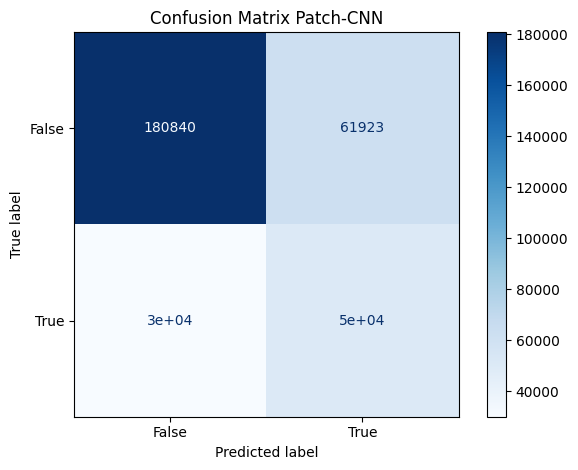

In [75]:
plot_confusion_matrix(y_true_all, y_pred_patch_all, title='Confusion Matrix Patch-CNN', report=False)

### 3.3. Comparison

In [76]:
@ipw.interact(index=ipw.IntSlider(min=0, max=len(X_test_100) - 1, description='Test Index'))
def plot_comparison_results(index):
 
    original_img_cropped = X_test_100[index, :H_SEG, :W_SEG, :]
    true_mask_cropped_norm = y_test_100[index, :H_SEG, :W_SEG, :]
    true_mask_cropped_255 = (true_mask_cropped_norm * 255).astype(np.uint8)
    
    pred_proba_fcn_cropped = y_pred_proba_100[index, :H_SEG, :W_SEG, :]
    predicted_mask_fcn_bin_cropped = (pred_proba_fcn_cropped > 0.5).astype(np.uint8) * 255
    
    pred_proba_patch_cropped = y_pred_segmentation_cnn[index, :H_SEG, :W_SEG, :]
    predicted_mask_patch_bin_cropped = y_pred_segmentation_cnn_bin[index, :H_SEG, :W_SEG, :] * 255
    
    accuracy_fcn_img = accuracy_score(true_mask_cropped_norm.flatten(), (pred_proba_fcn_cropped > 0.5).flatten())

    accuracy_patch_img = accuracy_score(
        true_mask_cropped_norm.flatten(), 
        predicted_mask_patch_bin_cropped.flatten() / 255
    )
    
    fig, axes = plt.subplots(2, 3, figsize=(12, 7), constrained_layout=True)

    axes[0, 0].imshow(original_img_cropped)
    axes[0, 0].set_title("Original Cropped Image")
    axes[0, 0].axis('off')

    axes[1, 0].imshow(true_mask_cropped_255, cmap='gray')
    axes[1, 0].set_title("True Mask Cropped")
    axes[1, 0].axis('off')

    axes[0, 1].imshow(predicted_mask_fcn_bin_cropped, cmap='gray')
    axes[0, 1].set_title(f"Full CNN Pred Mask (Acc: {accuracy_fcn_img:.4f})")
    axes[0, 1].axis('off')
    
    axes[1, 1].imshow(pred_proba_fcn_cropped, cmap='RdYlGn')
    axes[1, 1].set_title("Full CNN Probability Map")
    axes[1, 1].axis('off')

    axes[0, 2].imshow(predicted_mask_patch_bin_cropped, cmap='gray')
    axes[0, 2].set_title(f"Patch-CNN Pred Mask (Acc: {accuracy_patch_img:.4f})")
    axes[0, 2].axis('off')
    
    axes[1, 2].imshow(pred_proba_patch_cropped, cmap='RdYlGn')
    axes[1, 2].set_title("Patch-CNN Probability Map")
    axes[1, 2].axis('off')

    plt.show()

interactive(children=(IntSlider(value=0, description='Test Index', max=39), Output()), _dom_classes=('widget-i…

In [77]:
y_true_fcn_all = y_test_100.flatten()
y_pred_proba_fcn_all = y_pred_proba_100.flatten()

y_pred_proba_patch_all = y_pred_segmentation_cnn[:, :H_SEG, :W_SEG, :].flatten()

fpr_fcn, tpr_fcn, _ = roc_curve(y_true_fcn_all, y_pred_proba_fcn_all)
roc_auc_fcn = auc(fpr_fcn, tpr_fcn)

fpr_patch, tpr_patch, _ = roc_curve(y_true_all, y_pred_proba_patch_all)
roc_auc_patch = auc(fpr_patch, tpr_patch)

In [78]:
fpr_opt, tpr_opt = find_optimal_roc_point(fpr_fcn, tpr_fcn)

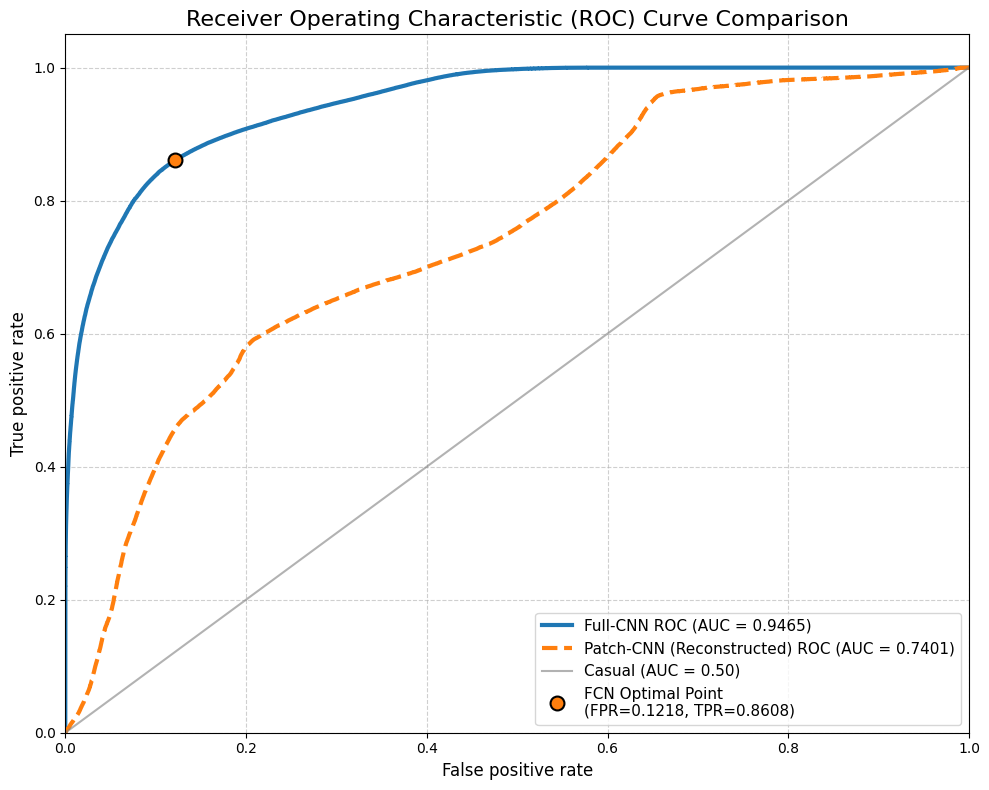

In [79]:
plt.figure(figsize=(10, 8))
plt.title('Receiver Operating Characteristic (ROC) Curve Comparison', fontsize=16)

# Plot Full-CNN ROC
plt.plot(fpr_fcn, tpr_fcn, color='#1f77b4', lw=3, label=f'Full-CNN ROC (AUC = {roc_auc_fcn:.4f})')

# Plot Patch-CNN ROC
plt.plot(fpr_patch, tpr_patch, color='#ff7f0e', lw=3, linestyle='--', label=f'Patch-CNN (Reconstructed) ROC (AUC = {roc_auc_patch:.4f})')

# Casual Comparison
plt.plot([0, 1], [0, 1], color='gray', lw=1.5, linestyle='-', alpha=0.6, label='Casual (AUC = 0.50)')

# Optimal Point for Full-CNN
plt.plot(
    fpr_opt, tpr_opt, 'o', markersize=10, 
    color='#ff7f0e', markeredgecolor='black', markeredgewidth=1.5, 
    label=f'FCN Optimal Point \n(FPR={fpr_opt:.4f}, TPR={tpr_opt:.4f})'
)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False positive rate', fontsize=12)
plt.ylabel('True positive rate', fontsize=12)
plt.legend(loc="lower right", fontsize=11)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()